In [1]:
# Basic library
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
from collections import Counter

# Feature Selection
from scipy.stats import chi2_contingency

# Data preprocessing
from sklearn.model_selection import train_test_split

import pickle

# Evaluation
# from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import average_precision_score, roc_auc_score
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

In [2]:
import sys
import numpy as np
import matplotlib
import seaborn as sns
import tqdm
import sklearn
import pandas


print ( "Python", sys.version )
print ( "Numpy", np.__version__ )
print ( "Matplotlib", matplotlib.__version__ )
print ( "Seaborn", sns.__version__ )
print ( "tqdm", tqdm.__version__ )
print ( "scikit-learn", sklearn.__version__ )
print ( "pandas", pandas.__version__ )




Python 3.7.5 (default, Oct 25 2019, 10:52:18) 
[Clang 4.0.1 (tags/RELEASE_401/final)]
Numpy 1.17.3
Matplotlib 3.0.3
Seaborn 0.9.0
tqdm 4.40.0
scikit-learn 0.22.1
pandas 0.25.3


In [3]:
# Set dataframe display
pd.set_option('display.max_columns', None)  # default = 20
pd.set_option('display.expand_frame_repr', False) # default = True
pd.set_option('display.max_colwidth', -1) # default = 50
pd.set_option('display.max_rows', None) # default = 60
pd.set_option('display.float_format', lambda x: '%.3f' % x)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
def percent_countplot(df, col_name, col_hue = None, order_by_value = False, topn = 0, dropna = True,
                      orient = 'v', annot_percent = True, figsize = (14,8)):
    
    import matplotlib
    import matplotlib.pyplot as plt
    import seaborn as sns

    # Fill Paramter
    fs = 16 # Font size
    x_data = df.copy()
    x_col = col_name # column to count
    x_hue = col_hue # For divide column
    tittle = 'Distribution by '+x_col

    matplotlib.rc('xtick', labelsize = fs-2)     
    matplotlib.rc('ytick', labelsize = fs-2)
    fig = plt.figure(figsize= figsize)
    
    data_col = x_data   
        
    # topn > 0 we will combine the rest as "Other"
    if topn:
        counts = data_col[x_col].value_counts()
        topn_name = counts.nlargest(topn).index
        data_col[x_col] = data_col[x_col].where(data_col[x_col].isin(topn_name), other = 'Other')
    elif topn == 0:
        topn = data_col[x_col].nunique()
        
    # arrange order by value or index?
    if order_by_value :
        counts = data_col[x_col].value_counts()
        max_count = max(counts) # for adjust text alignment
    else:
        if str in list(map(type,data_col[x_col])) or not dropna:
            data_col[x_col] = data_col[x_col].astype(str)
        counts = data_col[x_col].value_counts().sort_index()
        max_count = max(counts.iloc[:topn]) # for adjust text alignment
        
    if orient == 'v':
        ax = sns.countplot(x = x_col, hue = x_hue, data= data_col, order = counts.iloc[:topn+1].index)
        ax.set_xlabel(x_col, color = 'r', fontsize = fs, fontweight='bold')
        ax.set_ylabel('Frequency', color = 'b', fontsize = fs, fontweight='bold')
        # Set rotation of xticks if name is too long
        data_col[x_col] = data_col[x_col].astype(str)
        xrot = 15 if max(list(map(len,data_col[x_col].unique()))) > 10 else 0
        ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
    elif orient == 'h':
        ax = sns.countplot(y = x_col, hue = x_hue, data= data_col, order = counts.iloc[:topn+1].index)
        ax.set_ylabel(x_col, color = 'b', fontsize = fs, fontweight='bold')
        ax.set_xlabel('Frequency', color = 'r', fontsize = fs, fontweight='bold')
        xrot = 0
        ax.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
        
    total_count = sum(counts) # for calculate percentage
    # print(counts)
    
    # fig.suptitle('test title', fontsize=12)
    ax.set_title(tittle, fontsize = fs, fontweight='bold' )

    plt.xticks(rotation=xrot, color='r', size=16)
    plt.yticks(rotation=0, color='b', size=16)
    
    if x_hue == None and orient == 'v':
        for i, v in enumerate(counts[:topn+1]):
            ax.text(x = i, y=v + max_count*0.01 , s='{:,}'.format(v), horizontalalignment='center', color='black', fontweight='bold')
            if annot_percent:
                ax.text(x = i, y= v/2, s=str('{:.2f}'.format(v*100/total_count))+'%',
                        color='yellow', fontweight='bold', size = 14,
                        horizontalalignment='center', 
                        verticalalignment='center' 
                        )
    elif x_hue == None and orient == 'h':
        for i, v in enumerate(counts[:topn+1]):
            ax.text(x = v + max_count*0.03, y=i , s='{:,}'.format(v), horizontalalignment='center', color='black', fontweight='bold')
            if annot_percent:
                ax.text(x = v/2, y=i , s=str('{:.2f}'.format(v*100/total_count))+'%',
                        color='yellow', fontweight='bold', size = 14,
                        horizontalalignment='center', 
                        verticalalignment='center' 
                        )
    return ax

In [5]:
df = pd.read_csv('DrugAllergyKaggle_v3_050720_Imputed.csv')
# df = df.sort_values(by = 'Patient_ID').reset_index(drop=True); 
df.head()

,Patient_ID,Gender,Age_Year,ELISpot_Control,ELISpot_Result,Naranjo_Category,Steroid_Usage,Underlying_Condition_A,Underlying_Condition_B,Underlying_Condition_C,Underlying_Condition_D,Underlying_Condition_E,Suspicion_Score,Allergic_Reaction_Group,Drug_Group,Drug_Rechallenge_Result,Ex_Time_group
0,2,1,26,2504,0.000,1.000,1,0.000,0,0,0.000,0.000,2,2.000,2,nan,0
1,7,0,75,1868,51.000,2.000,0,0.000,0,0,0.000,0.000,2,6.000,4,1.000,0
2,13,0,81,1617,10.000,1.000,1,1.000,0,0,1.000,1.000,2,5.000,1,nan,0
3,13,0,81,1617,10.000,1.000,1,1.000,0,0,1.000,1.000,2,5.000,3,nan,0
4,18,1,60,3136,0.000,1.000,0,0.000,0,0,1.000,1.000,3,8.000,1,nan,0


In [6]:
print ("Rows     : " ,df.shape[0])
print ("Columns  : " ,df.shape[1])
print ("\nFeatures : \n" ,df.columns.tolist())
print ("\nMissing values :  ", df.isnull().sum().values.sum())
n_uniq = df.nunique()
print ("\nUnique values :  \n",n_uniq)
print ("\nTotal Unique values :  {:,}".format(n_uniq.values.sum()))

Rows     :  798
Columns  :  17

Features : 
 ['Patient_ID', 'Gender', 'Age_Year', 'ELISpot_Control', 'ELISpot_Result', 'Naranjo_Category', 'Steroid_Usage', 'Underlying_Condition_A', 'Underlying_Condition_B', 'Underlying_Condition_C', 'Underlying_Condition_D', 'Underlying_Condition_E', 'Suspicion_Score', 'Allergic_Reaction_Group', 'Drug_Group', 'Drug_Rechallenge_Result', 'Ex_Time_group']

Missing values :   684

Unique values :  
 Patient_ID                 298
Gender                     2  
Age_Year                   94 
ELISpot_Control            260
ELISpot_Result             77 
Naranjo_Category           4  
Steroid_Usage              2  
Underlying_Condition_A     2  
Underlying_Condition_B     2  
Underlying_Condition_C     2  
Underlying_Condition_D     2  
Underlying_Condition_E     2  
Suspicion_Score            3  
Allergic_Reaction_Group    8  
Drug_Group                 8  
Drug_Rechallenge_Result    2  
Ex_Time_group              4  
dtype: int64

Total Unique values :  77

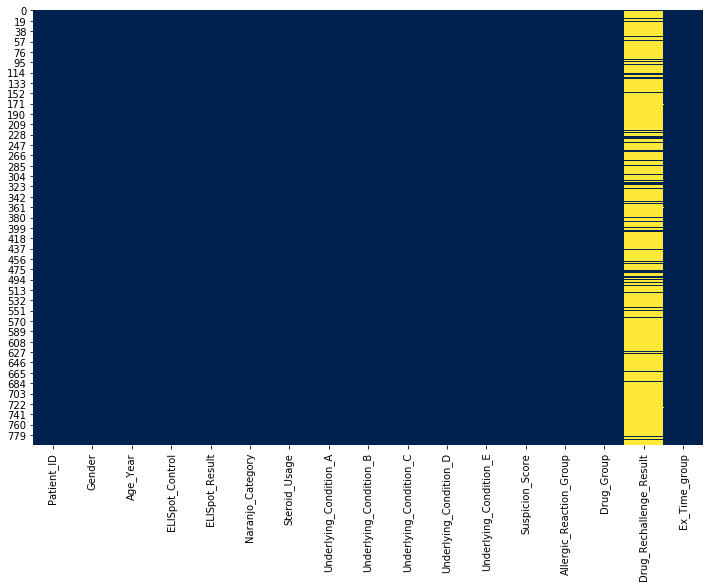

In [7]:
plt.figure(figsize=(12,8))
sns.heatmap(df.isnull(), cbar=False, cmap = 'cividis');

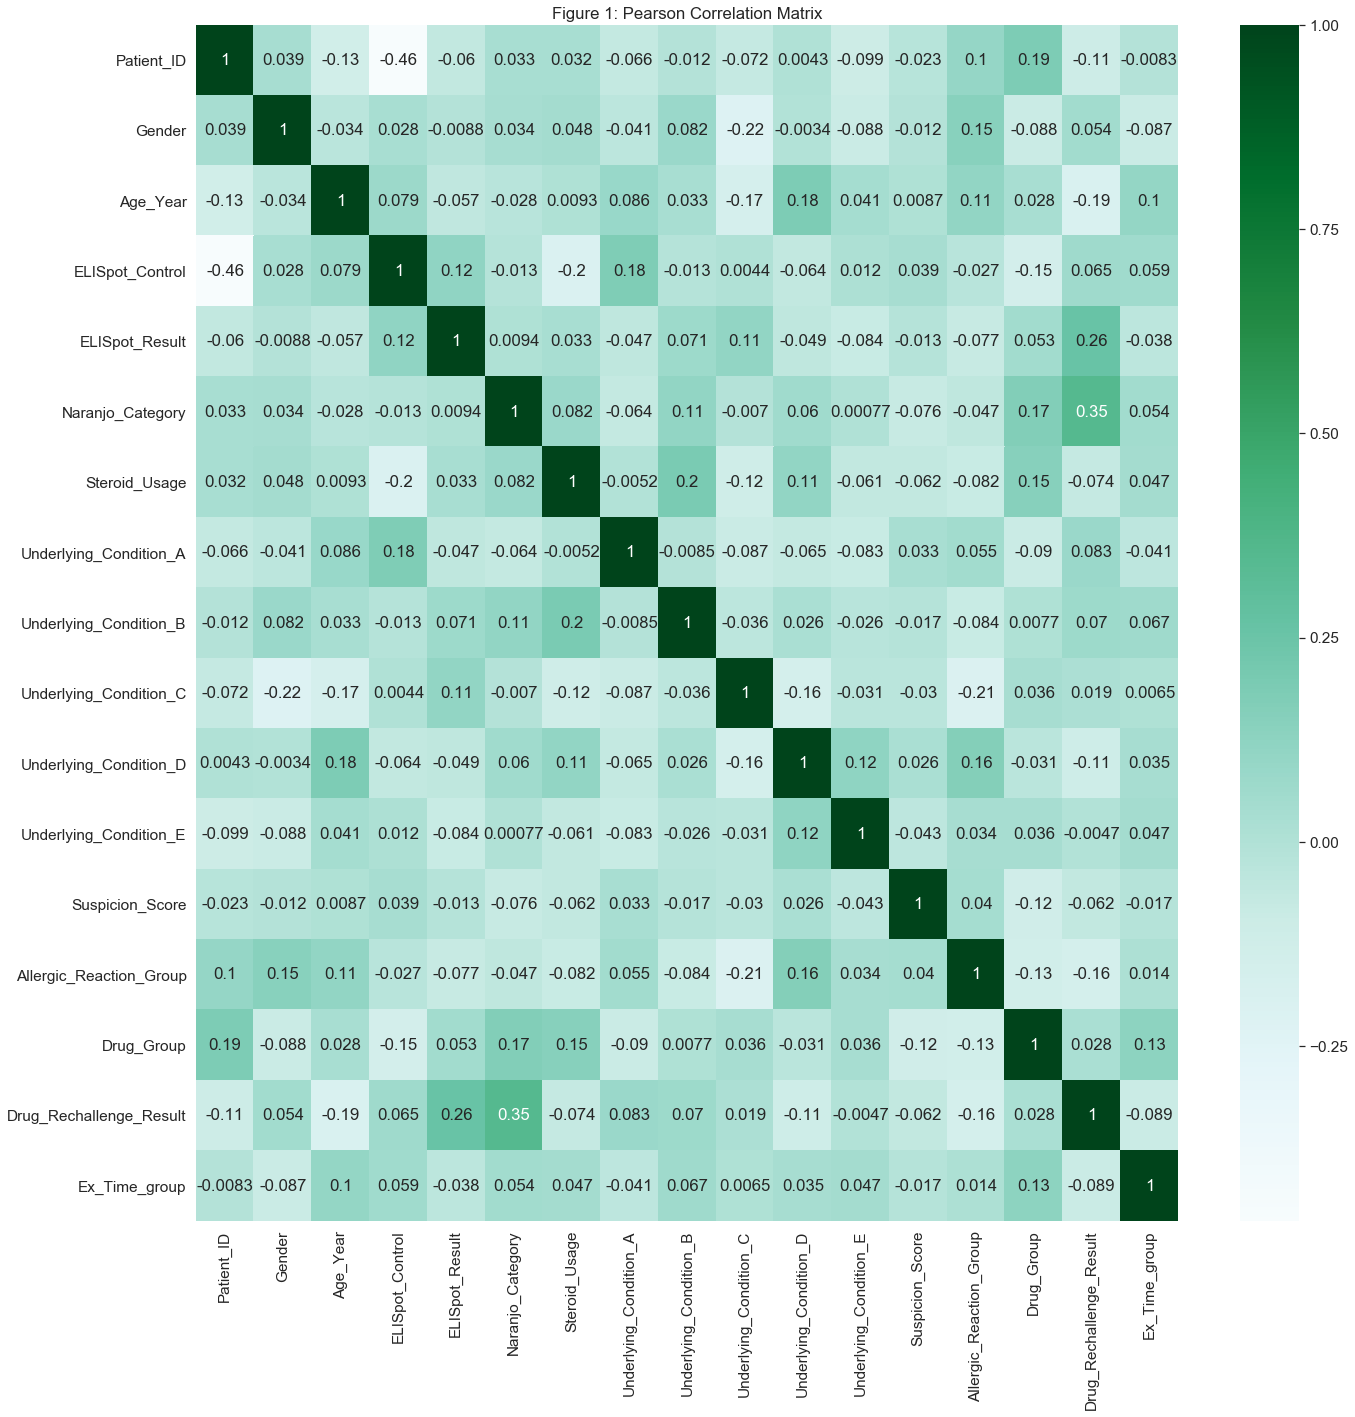

In [8]:
plt.figure(figsize=(22,22)) 
sns.set(font_scale=1.4)
plt.title('Figure 1: Pearson Correlation Matrix')
sns.heatmap(df.corr(), annot=True, cmap='BuGn')

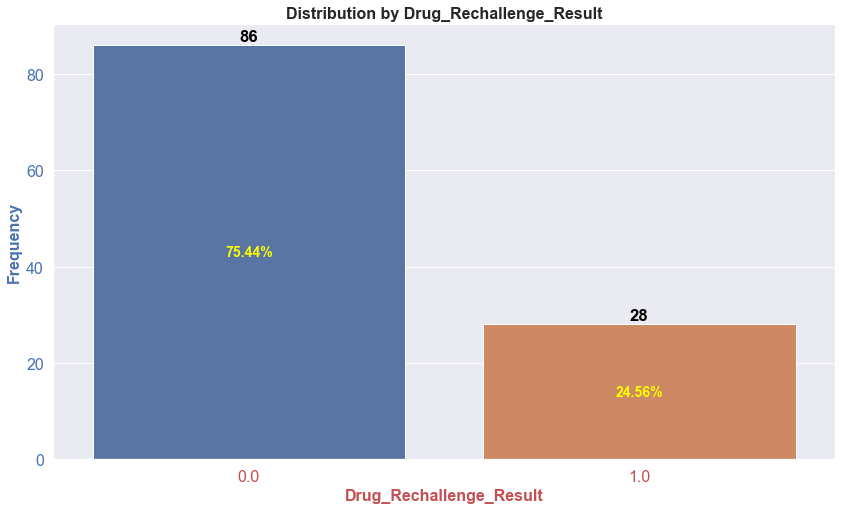

In [9]:
percent_countplot(df, col_name= 'Drug_Rechallenge_Result')

In [10]:
df.Drug_Rechallenge_Result.value_counts(dropna=False)

nan      684
0.000    86 
1.000    28 
Name: Drug_Rechallenge_Result, dtype: int64

# One Hot Encoding

In [11]:
# Before we use 'get_dummies' function we have to convert data type of all feature to be 'category' 
def cvt_type(df, col_list, dtype = 'category'):
    for col in col_list:
        df[col] = df[col].astype(int).astype('category')
    return df

In [12]:
cat_col = ['Gender', 'Naranjo_Category', 'Steroid_Usage', 'Underlying_Condition_A',
       'Underlying_Condition_B', 'Underlying_Condition_C',
       'Underlying_Condition_D', 'Underlying_Condition_E', 'Suspicion_Score',
       'Allergic_Reaction_Group', 'Drug_Group','Ex_Time_group']

df_cat = cvt_type(df, col_list=cat_col)
df_cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 798 entries, 0 to 797
Data columns (total 17 columns):
Patient_ID                 798 non-null int64
Gender                     798 non-null category
Age_Year                   798 non-null int64
ELISpot_Control            798 non-null int64
ELISpot_Result             798 non-null float64
Naranjo_Category           798 non-null category
Steroid_Usage              798 non-null category
Underlying_Condition_A     798 non-null category
Underlying_Condition_B     798 non-null category
Underlying_Condition_C     798 non-null category
Underlying_Condition_D     798 non-null category
Underlying_Condition_E     798 non-null category
Suspicion_Score            798 non-null category
Allergic_Reaction_Group    798 non-null category
Drug_Group                 798 non-null category
Drug_Rechallenge_Result    114 non-null float64
Ex_Time_group              798 non-null category
dtypes: category(12), float64(2), int64(3)
memory usage: 42.5 KB


In [13]:
print('Unique value')
for col in cat_col:
    print('{0:25}: {1:}'.format(col, df[col].unique().ravel()))

Unique value
Gender                   : [1 0]
Naranjo_Category         : [1 2 0 3]
Steroid_Usage            : [1 0]
Underlying_Condition_A   : [0 1]
Underlying_Condition_B   : [0 1]
Underlying_Condition_C   : [0 1]
Underlying_Condition_D   : [0 1]
Underlying_Condition_E   : [0 1]
Suspicion_Score          : [2 3 1]
Allergic_Reaction_Group  : [2 6 5 8 1 3 7 4]
Drug_Group               : [2 4 1 3 6 7 5 8]
Ex_Time_group            : [0 1 3 2]


In [14]:
# Get dummies
df_encoded = pd.get_dummies(df_cat, prefix_sep='_', drop_first=False)
print(df_encoded.shape)
df_encoded.head()

(798, 46)


,Patient_ID,Age_Year,ELISpot_Control,ELISpot_Result,Drug_Rechallenge_Result,Gender_0,Gender_1,Naranjo_Category_0,Naranjo_Category_1,Naranjo_Category_2,Naranjo_Category_3,Steroid_Usage_0,Steroid_Usage_1,Underlying_Condition_A_0,Underlying_Condition_A_1,Underlying_Condition_B_0,Underlying_Condition_B_1,Underlying_Condition_C_0,Underlying_Condition_C_1,Underlying_Condition_D_0,Underlying_Condition_D_1,Underlying_Condition_E_0,Underlying_Condition_E_1,Suspicion_Score_1,Suspicion_Score_2,Suspicion_Score_3,Allergic_Reaction_Group_1,Allergic_Reaction_Group_2,Allergic_Reaction_Group_3,Allergic_Reaction_Group_4,Allergic_Reaction_Group_5,Allergic_Reaction_Group_6,Allergic_Reaction_Group_7,Allergic_Reaction_Group_8,Drug_Group_1,Drug_Group_2,Drug_Group_3,Drug_Group_4,Drug_Group_5,Drug_Group_6,Drug_Group_7,Drug_Group_8,Ex_Time_group_0,Ex_Time_group_1,Ex_Time_group_2,Ex_Time_group_3
0,2,26,2504,0.000,nan,0,1,0,1,0,0,0,1,1,0,1,0,1,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
1,7,75,1868,51.000,1.000,1,0,0,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0
2,13,81,1617,10.000,nan,1,0,0,1,0,0,0,1,0,1,1,0,1,0,0,1,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
3,13,81,1617,10.000,nan,1,0,0,1,0,0,0,1,0,1,1,0,1,0,0,1,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
4,18,60,3136,0.000,nan,0,1,0,1,0,0,1,0,1,0,1,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0


# Split data to train and test set

In [15]:
df_data = df_encoded.dropna()
NaN_idx = ~df_encoded.index.isin(df_data.index) # Store [True, False] array
# NaN_index = df_encoded[~df_encoded.index.isin(df_data.index)].index # Store index
df_NaN = df_encoded[NaN_idx] 
df_NaN.shape

(684, 46)

In [16]:
df_data.Patient_ID.nunique()

77

In [62]:
df_test_pos = df_data[df_data.Drug_Rechallenge_Result == 1].sample(10,random_state=7)
df_test_neg = df_data[df_data.Drug_Rechallenge_Result == 0].sample(10,random_state=7)
df_test = pd.concat([df_test_pos,df_test_neg])
df_test_idx = df_test_pos.index.tolist() + df_test_neg.index.tolist()
print(df_test.shape)
df_test.Drug_Rechallenge_Result.value_counts()

(20, 46)


0.000    10
1.000    10
Name: Drug_Rechallenge_Result, dtype: int64

In [61]:
df_test.to_csv('Drug_allergy_test_set.csv', index=False)

In [18]:
df_train = df_data[~df_data.index.isin(df_test_idx)]
print(df_train.shape)
df_train.Drug_Rechallenge_Result.value_counts()

(94, 46)


0.000    76
1.000    18
Name: Drug_Rechallenge_Result, dtype: int64

In [19]:
# Look whether it has same patient in both train and test set
df_train.Patient_ID.isin(df_test.Patient_ID).sum()

13

# Fit Model

In [20]:
# Training set
X_encoded = df_train.drop(['Drug_Rechallenge_Result','Patient_ID'], axis=1)
y_data = df_train[['Drug_Rechallenge_Result']]

# Test set 
X_encoded_test = df_test.drop(['Drug_Rechallenge_Result','Patient_ID'], axis=1)
y_data_test = df_test[['Drug_Rechallenge_Result']]

In [21]:
from sklearn.linear_model import LogisticRegression
LogisticRegression()

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [22]:
# Logistic Regression
def LogReg_HPTune_w_OverSam(X, y, verbose = 0):
    """
    Purpose
    ----------
    Choosing a set of optimal hyperparameters for a Logistic Regression Classifier

    Parameters
    ----------
    X: Data set with all feature or predictor
    y: Data set with Class
    verbose: 0 mean not show summary of tuning
             1 mean show summary of tuning
    Returns:
    ----------
    Returns grid search model of Logistic Regression Classifier with tuned hyperparameter
    """  
    from sklearn.linear_model import LogisticRegression
    from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
    
    # Oversampling
    X, y = makeOverSamplesADASYN(X,y)
    
    # Logistic Regression Classifier
    LogReg_clf = LogisticRegression(random_state = 7, max_iter=1000, fit_intercept=False)
    
    # Create regularization hyperparameter space
    C = [0.1,1,10] #np.logspace(-1, 1, 50)
    
    # Create regularization penalty space
    penalty = ['none', 'l2']
    
    # Create class weight mode space
    class_weight = [None, 'balanced']
    
    # Create solver function space
    solver = ['saga', 'lbfgs', 'newton-cg']
    
    # 
    fit_intercept = [True, False]

    
    # Define Search Param
    param_dist = dict(C = C,
#                       penalty = penalty,
#                       class_weight = class_weight,
#                       solver = solver,
#                       fit_intercept = fit_intercept,
                     )
    rs = RandomizedSearchCV(estimator=LogReg_clf,
                            param_distributions=param_dist,
                            refit=True,
                            scoring=score_param,
                            n_iter=n_iter_search,
                            cv=cv,
                            n_jobs=-1,
                            verbose =verbose,
                            random_state=7,
                            iid=True)
    if verbose == 1:
        start = time()    
        rs.fit(X,y)
        print("RandomizedSearchCV took %.2f seconds for %d candidate parameter settings." 
              % (time() - start, len(rs.cv_results_['params'])))

    elif verbose == 0:
        rs.fit(X,y)
    
    # Best parameter from RandomizedSearchCV
    bs_C = rs.best_params_['C'] 
#     bs_penalty = rs.best_params_['penalty'] 
#     bs_class_weight = rs.best_params_['class_weight']
#     bs_solver = rs.best_params_['solver'] 
#     bs_fit_intercept = rs.best_params_['fit_intercept']
    d_C = np.log10(bs_C)
    
    param_grid = dict(C = np.append(bs_C,np.logspace(d_C-4,d_C+4,num=50)),
#                       penalty = [bs_penalty],
#                       class_weight = [bs_class_weight],
#                       solver = [bs_solver],
                      fit_intercept = fit_intercept #[bs_fit_intercept],
                     )
    gs = GridSearchCV(estimator=LogReg_clf, 
                      param_grid=param_grid,
                      refit=True,
                      scoring=score_param,
                      cv=cv,
                      n_jobs=-1,
                      verbose =verbose,
                      iid=True)
    
    if verbose == 1:
        start = time()
        gs.fit(X,y)
        print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
              % (time() - start, len(gs.cv_results_['params'])))

    elif verbose == 0:
        gs.fit(X,y)
    
    return rs, gs

In [23]:
def makeOverSamplesADASYN(X,y):
    from imblearn.over_sampling import ADASYN
    """
    Purpose
    ----------
    Increasing the observation of minority class 

    Parameters
    ----------
    X: Independent Variable in DataFrame
    y: Dependent Variable in Pandas DataFrame format
    Returns:
    ----------
    Returns Independent and Dependent variable with resampling minority class
    """
    X_resampled, y_resampled = ADASYN(random_state=7).fit_sample(X, y)
    return(X_resampled, y_resampled)

In [24]:
np.logspace(1-4,1+4,num=50)

array([1.00000000e-03, 1.45634848e-03, 2.12095089e-03, 3.08884360e-03,
       4.49843267e-03, 6.55128557e-03, 9.54095476e-03, 1.38949549e-02,
       2.02358965e-02, 2.94705170e-02, 4.29193426e-02, 6.25055193e-02,
       9.10298178e-02, 1.32571137e-01, 1.93069773e-01, 2.81176870e-01,
       4.09491506e-01, 5.96362332e-01, 8.68511374e-01, 1.26485522e+00,
       1.84206997e+00, 2.68269580e+00, 3.90693994e+00, 5.68986603e+00,
       8.28642773e+00, 1.20679264e+01, 1.75751062e+01, 2.55954792e+01,
       3.72759372e+01, 5.42867544e+01, 7.90604321e+01, 1.15139540e+02,
       1.67683294e+02, 2.44205309e+02, 3.55648031e+02, 5.17947468e+02,
       7.54312006e+02, 1.09854114e+03, 1.59985872e+03, 2.32995181e+03,
       3.39322177e+03, 4.94171336e+03, 7.19685673e+03, 1.04811313e+04,
       1.52641797e+04, 2.22299648e+04, 3.23745754e+04, 4.71486636e+04,
       6.86648845e+04, 1.00000000e+05])

In [25]:
# accuracy
# balanced_accuracy
# average_precision
# roc_auc
# f1
# f1_micro
score_param = 'accuracy' # Score for tune model
n_iter_search = 3 # Max candidate parameter for RandomizedSearchCV
cv = 5 # Number of k-fold cross validation
LogReg_rs, LogReg_gs = LogReg_HPTune_w_OverSam(X_encoded,y_data.values.ravel(),  verbose = 0)

Using TensorFlow backend.


In [26]:
print(LogReg_gs.best_score_)
print(LogReg_rs.best_score_)
print(LogReg_rs.best_params_)
print(LogReg_gs.best_params_)

print('='*25)
print('Training set performance')
print('='*25)
print(classification_report(LogReg_gs.predict(X_encoded),y_data))

print('='*25)
print('Test set performance')
print('='*25)
print(classification_report(LogReg_gs.predict(X_encoded_test),y_data_test))

print(LogReg_gs.best_estimator_)

0.8543046357615894
0.8543046357615894
{'C': 10}
{'C': 10.0, 'fit_intercept': False}
Training set performance
              precision    recall  f1-score   support

         0.0       0.97      0.88      0.93        84
         1.0       0.44      0.80      0.57        10

    accuracy                           0.87        94
   macro avg       0.71      0.84      0.75        94
weighted avg       0.92      0.87      0.89        94

Test set performance
              precision    recall  f1-score   support

         0.0       0.70      0.70      0.70        10
         1.0       0.70      0.70      0.70        10

    accuracy                           0.70        20
   macro avg       0.70      0.70      0.70        20
weighted avg       0.70      0.70      0.70        20

LogisticRegression(C=10.0, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
 

In [27]:
print(LogReg_gs.predict_proba(X_encoded_test).shape)
print(LogReg_gs.predict(X_encoded_test).reshape(-1,1).shape)
print(np.array(y_data_test).reshape(-1,1).shape)

print(LogReg_gs.predict_proba(X_encoded_test)[:,1].shape)

(20, 2)
(20, 1)
(20, 1)
(20,)


In [28]:
compare_predict_prob = np.append(LogReg_gs.predict_proba(X_encoded_test),(LogReg_gs.predict(X_encoded_test).reshape(-1,1)), axis = 1)
compare_predict_prob = np.append(compare_predict_prob,np.array(y_data_test).reshape(-1,1),axis=1)
compare_predict_prob

array([[0.86400409, 0.13599591, 0.        , 1.        ],
       [0.20605308, 0.79394692, 1.        , 1.        ],
       [0.36960534, 0.63039466, 1.        , 1.        ],
       [0.21891932, 0.78108068, 1.        , 1.        ],
       [0.49127642, 0.50872358, 1.        , 1.        ],
       [0.06015876, 0.93984124, 1.        , 1.        ],
       [0.99870094, 0.00129906, 0.        , 1.        ],
       [0.18210271, 0.81789729, 1.        , 1.        ],
       [0.94815408, 0.05184592, 0.        , 1.        ],
       [0.05506585, 0.94493415, 1.        , 1.        ],
       [0.97572779, 0.02427221, 0.        , 0.        ],
       [0.88313285, 0.11686715, 0.        , 0.        ],
       [0.76097189, 0.23902811, 0.        , 0.        ],
       [0.17337757, 0.82662243, 1.        , 0.        ],
       [0.07515474, 0.92484526, 1.        , 0.        ],
       [0.95341935, 0.04658065, 0.        , 0.        ],
       [0.08046459, 0.91953541, 1.        , 0.        ],
       [0.83330357, 0.16669643,

In [29]:
total_NaN = len(df_NaN)
total_NaN

684

In [30]:
# Sampling and drop
df_NaN_temp = df_NaN.copy()
n_sam = 100
df_NaN_subset = df_NaN_temp.sample(n_sam, random_state=7)
df_NaN_temp = df_NaN_temp.drop(df_NaN_subset.index)

In [31]:
print(df_NaN_subset.shape)

(100, 46)


In [32]:
X_encoded_NaN = df_NaN_subset.drop(['Drug_Rechallenge_Result','Patient_ID'], axis=1)
y_data_NaN = df_NaN_subset[['Drug_Rechallenge_Result']]

In [33]:
y_data.index

Int64Index([  1,  16,  21,  24,  28,  35,  44,  48,  53,  55,  57,  59,  92,
             95, 105, 108, 112, 117, 118, 119, 130, 143, 169, 202, 221, 225,
            232, 233, 235, 236, 243, 258, 259, 260, 266, 276, 277, 285, 288,
            292, 299, 302, 308, 312, 317, 318, 320, 321, 327, 336, 351, 352,
            355, 367, 369, 384, 387, 388, 395, 399, 405, 406, 407, 440, 444,
            462, 464, 465, 478, 480, 481, 482, 486, 489, 490, 491, 492, 494,
            495, 497, 500, 506, 518, 546, 552, 564, 627, 630, 659, 661, 682,
            778, 782, 788],
           dtype='int64')

In [34]:
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

compare_predict_prob = np.append(LogReg_gs.predict_proba(X_encoded_NaN)[:,1].reshape(-1,1),(LogReg_gs.predict(X_encoded_NaN).reshape(-1,1)), axis = 1)
compare_predict_prob[:5]

array([[0.183, 0.000],
       [0.003, 0.000],
       [0.007, 0.000],
       [0.001, 0.000],
       [0.894, 1.000]])

In [35]:
Counter(LogReg_gs.predict(X_encoded_NaN))

Counter({0.0: 75, 1.0: 25})

In [36]:
X_encoded_NaN.index

Int64Index([375, 251, 213,  14, 334, 532, 691,  74, 588, 295, 505, 223, 274,
            451, 361, 244, 721, 702, 543, 538, 458, 228,  71, 625, 456,  10,
            403, 460, 436, 760, 531, 220, 554, 300, 692, 621, 734, 642, 378,
            657, 138, 356, 180, 530, 394, 779, 174, 173, 671, 665, 139, 342,
            158, 570, 526, 653, 337, 284, 555, 568, 310, 201, 227, 301, 345,
            644, 265, 727,  84, 525, 729, 736, 315, 453, 707, 557, 268, 624,
            514, 536, 560, 780, 127, 452, 753, 404, 695, 600, 684, 186, 672,
             67, 192, 726, 170, 797, 305,  26, 390, 678],
           dtype='int64')

In [37]:
high_confidence_idx = []
predict_result = []
threshold_pos = 0.8
for idx in X_encoded_NaN.index:
    Pos_confidence = LogReg_gs.predict_proba(X_encoded_NaN.loc[[idx]])[:,1]
    if Pos_confidence > threshold_pos:
        high_confidence_idx.append(idx)
        predict_class = LogReg_gs.predict(X_encoded_NaN.loc[[idx]])
        predict_result.append(predict_class)
    elif Pos_confidence < (1-threshold_pos):
        high_confidence_idx.append(idx)
        predict_class = LogReg_gs.predict(X_encoded_NaN.loc[[idx]])
        predict_result.append(predict_class)

In [38]:
count = 0
for idx, class_pred in zip(high_confidence_idx,predict_result):
    print(idx, class_pred[0])
    count += 1
    if count >5: break

375 0.0
251 0.0
213 0.0
14 0.0
334 1.0
532 0.0


In [39]:
predict_result[:5]

[array([0.000]),
 array([0.000]),
 array([0.000]),
 array([0.000]),
 array([1.000])]

In [40]:
df_feature_NaN = X_encoded_NaN.loc[high_confidence_idx]
print(df_feature_NaN.shape)
df_feature_NaN.head()

(70, 44)


,Age_Year,ELISpot_Control,ELISpot_Result,Gender_0,Gender_1,Naranjo_Category_0,Naranjo_Category_1,Naranjo_Category_2,Naranjo_Category_3,Steroid_Usage_0,Steroid_Usage_1,Underlying_Condition_A_0,Underlying_Condition_A_1,Underlying_Condition_B_0,Underlying_Condition_B_1,Underlying_Condition_C_0,Underlying_Condition_C_1,Underlying_Condition_D_0,Underlying_Condition_D_1,Underlying_Condition_E_0,Underlying_Condition_E_1,Suspicion_Score_1,Suspicion_Score_2,Suspicion_Score_3,Allergic_Reaction_Group_1,Allergic_Reaction_Group_2,Allergic_Reaction_Group_3,Allergic_Reaction_Group_4,Allergic_Reaction_Group_5,Allergic_Reaction_Group_6,Allergic_Reaction_Group_7,Allergic_Reaction_Group_8,Drug_Group_1,Drug_Group_2,Drug_Group_3,Drug_Group_4,Drug_Group_5,Drug_Group_6,Drug_Group_7,Drug_Group_8,Ex_Time_group_0,Ex_Time_group_1,Ex_Time_group_2,Ex_Time_group_3
375,73,1244,0.000,0,1,0,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0
251,88,1600,0.000,1,0,0,1,0,0,1,0,1,0,0,1,1,0,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
213,60,2560,1.000,0,1,0,1,0,0,1,0,1,0,1,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0
14,48,820,0.000,1,0,0,1,0,0,1,0,1,0,1,0,0,1,1,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0
334,30,1432,0.000,1,0,0,1,0,0,1,0,1,0,1,0,0,1,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0


In [41]:
# Create dataframe to store high confidence result
df_predict_NaN = pd.DataFrame(predict_result, columns=['Drug_Rechallenge_Result'], index=high_confidence_idx)
print(df_predict_NaN.shape)
df_predict_NaN.head()

(70, 1)


,Drug_Rechallenge_Result
375,0.000
251,0.000
213,0.000
14,0.000
334,1.000


In [42]:
y_data.head()

,Drug_Rechallenge_Result
1,1.000
16,0.000
21,0.000
24,0.000
28,0.000


In [43]:
# Concat new predicted data to X_encoded and y_data
print(X_encoded.shape)
X_encoded_new = pd.concat([X_encoded,df_feature_NaN])
print(X_encoded_new.shape)
print(y_data.shape)
y_data_new = pd.concat([y_data,df_predict_NaN])
print(y_data_new.shape)

(94, 44)
(164, 44)
(94, 1)
(164, 1)


In [44]:
df_predict_NaN.isnull().sum()

Drug_Rechallenge_Result    0
dtype: int64

In [45]:
y_data_new.isnull().sum()
# y_data_new

Drug_Rechallenge_Result    0
dtype: int64

In [46]:
score_param = 'accuracy' # Score for tune model
n_iter_search = 3 # Max candidate parameter for RandomizedSearchCV
cv = 5 # Number of k-fold cross validation
LogReg_rs, LogReg_gs = LogReg_HPTune_w_OverSam(X_encoded_new,y_data_new.values.ravel())

/Users/PLoTAir/opt/anaconda3/envs/DS_project/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [47]:
print(LogReg_gs.best_score_)
print(LogReg_rs.best_score_)
print(LogReg_rs.best_params_)
print(LogReg_gs.best_params_)

print('='*25)
print('Training set performance')
print('='*25)
print(classification_report(LogReg_gs.predict(X_encoded_new),y_data_new))

print('='*25)
print('Test set performance')
print('='*25)
print(classification_report(LogReg_gs.predict(X_encoded_test),y_data_test))

0.9028776978417267
0.8992805755395683
{'C': 1}
{'C': 1.2067926406393288, 'fit_intercept': True}
Training set performance
              precision    recall  f1-score   support

         0.0       0.99      0.93      0.96       144
         1.0       0.66      0.95      0.78        20

    accuracy                           0.93       164
   macro avg       0.82      0.94      0.87       164
weighted avg       0.95      0.93      0.94       164

Test set performance
              precision    recall  f1-score   support

         0.0       0.70      0.70      0.70        10
         1.0       0.70      0.70      0.70        10

    accuracy                           0.70        20
   macro avg       0.70      0.70      0.70        20
weighted avg       0.70      0.70      0.70        20



In [48]:
# Append row which has low confident to df_NaN_temp
low_con_idx = df_NaN_subset[~df_NaN_subset.index.isin(high_confidence_idx)].index
low_con_idx

Int64Index([588, 458, 625, 460, 621, 734, 378, 657, 779, 139, 570, 526, 653,
            337, 284, 201, 345, 736, 453, 707, 268, 624, 560, 452, 600, 672,
             67, 192, 797,  26],
           dtype='int64')

In [49]:
print(df_NaN_temp.shape)
df_NaN_temp = pd.concat([df_NaN_temp,df_NaN_subset.loc[low_con_idx]])
df_NaN_temp.shape

(584, 46)


(614, 46)

In [50]:
def Pseudo_labeling(df_train, df_NaN, LogReg_HPTune_w_OverSam, n_sam = 100, verbose=0):
    
    print("Initiate base model from training set....")
    # Training set
    X_encoded = df_train.drop(['Drug_Rechallenge_Result','Patient_ID'], axis=1)
    y_data = df_train[['Drug_Rechallenge_Result']]
    
    print(X_encoded.shape)
    print(y_data.shape)
    
    score_param = 'accuracy' # Score for tune model
    n_iter_search = 100 # Max candidate parameter for RandomizedSearchCV
    cv = 5 # Number of k-fold cross validation
    LogReg_rs, LogReg_gs = LogReg_HPTune_w_OverSam(X_encoded,y_data.values.ravel(), verbose=0)
    
    # Make a copy of df_NaN
    df_NaN_temp = df_NaN.copy()
    
    n_sam = n_sam
    n_min = n_sam
    n_frac = n_sam
    if type(n_sam) != int:
        n_sam = n_frac * len(y_data)
        n_min = 100
    n_round = 0
    
    print("Start Active Learning Process")
    
    while len(df_NaN_temp) > n_min and len(df_NaN_temp) > n_sam:
        n_round += 1
        print("Round: ", n_round, "\nProcessing....")
        
        # Sampling n_sam sample to predict class and store idx with high confidence
        if type(n_frac) != int:
            n_sam = n_frac * len(y_data)
        df_NaN_train = df_NaN_temp.sample(n = int(n_sam), random_state=7)
        df_NaN_temp = df_NaN_temp.drop(df_NaN_train.index)
        
        X_encoded_NaN = df_NaN_train.drop(['Drug_Rechallenge_Result','Patient_ID'], axis=1)
#         y_data_NaN = df_NaN_train[['Drug_Rechallenge_Result']]

        # Search idx with high predict_proba
        high_confidence_idx = []
        predict_result = []
        threshold_pos = 0.8
        for idx in X_encoded_NaN.index:
            Pos_confidence = LogReg_gs.predict_proba(X_encoded_NaN.loc[[idx]])[:,1]
            if Pos_confidence > threshold_pos:
                high_confidence_idx.append(idx)
                predict_class = LogReg_gs.predict(X_encoded_NaN.loc[[idx]])
                predict_result.append(predict_class)
            elif Pos_confidence < (1-threshold_pos):
                high_confidence_idx.append(idx)
                predict_class = LogReg_gs.predict(X_encoded_NaN.loc[[idx]])
                predict_result.append(predict_class)

        # Create dataframe to store high confidence result
        df_feature_NaN = X_encoded_NaN.loc[high_confidence_idx]
        df_predict_NaN = pd.DataFrame(predict_result, columns=['Drug_Rechallenge_Result'], index=high_confidence_idx)

        # Concat new predicted data to X_encoded and y_data
        X_encoded = pd.concat([X_encoded,df_feature_NaN])
        y_data = pd.concat([y_data,df_predict_NaN])
        
        print(X_encoded.shape)
        print(y_data.shape)

        # GridSearch CV - Retraining
        score_param = 'accuracy' # Score for tune model
        n_iter_search = 100 # Max candidate parameter for RandomizedSearchCV
        cv = 5 # Number of k-fold cross validation
        LogReg_rs, LogReg_gs = LogReg_HPTune_w_OverSam(X_encoded,y_data.values.ravel(), verbose=0)

        # Append row which has low confident to df_NaN_temp
        low_con_idx = df_NaN_train[~df_NaN_train.index.isin(high_confidence_idx)].index
        df_NaN_temp = pd.concat([df_NaN_temp,df_NaN_train.loc[low_con_idx]])
        
        # Display performance of each round
        print('Training score: ', LogReg_rs.best_score_)
        print('Test score: ', accuracy_score(LogReg_rs.predict(X_encoded_test),y_data_test))
        
    # If the rest NaN sample less than n_sam
    df_NaN_train = df_NaN_temp
    X_encoded_NaN = df_NaN_train.drop(['Drug_Rechallenge_Result','Patient_ID'], axis=1)
    predict_class = LogReg_gs.predict(X_encoded_NaN)
    df_predict_NaN = pd.DataFrame(predict_class, columns=['Drug_Rechallenge_Result'], index=X_encoded_NaN.index)
    
    # Concat new predicted data to X_encoded and y_data
    X_encoded = pd.concat([X_encoded,X_encoded_NaN])
    y_data = pd.concat([y_data,df_predict_NaN])   
    
    print("=========== Finish ===========")
    print(X_encoded.shape)
    print(y_data.shape)
    
    return X_encoded, y_data, LogReg_gs



In [51]:
score_param = 'accuracy' # Score for tune model
n_iter_search = 3 # Max candidate parameter for RandomizedSearchCV
cv = 5 # Number of k-fold cross validation

In [52]:
start = time()

X_encoded_new, y_data_new, LogReg_gs_final = Pseudo_labeling(df_train, df_NaN, LogReg_HPTune_w_OverSam, n_sam = 0.5)

t = time() - start
print('Execution time = ', t, ' seconds')

Initiate base model from training set....
(94, 44)
(94, 1)
Start Active Learning Process
Round:  1 
Processing....
(132, 44)
(132, 1)


/Users/PLoTAir/opt/anaconda3/envs/DS_project/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Training score:  0.8812785388127854
Test score:  0.65
Round:  2 
Processing....
(174, 44)
(174, 1)
Training score:  0.9139072847682119
Test score:  0.7
Round:  3 
Processing....
(217, 44)
(217, 1)
Training score:  0.935656836461126
Test score:  0.7
Round:  4 
Processing....
(282, 44)
(282, 1)
Training score:  0.9537815126050421
Test score:  0.7
Round:  5 
Processing....
(363, 44)
(363, 1)


/Users/PLoTAir/opt/anaconda3/envs/DS_project/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/PLoTAir/opt/anaconda3/envs/DS_project/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sc

Training score:  0.9704918032786886
Test score:  0.7
Round:  6 
Processing....
(502, 44)
(502, 1)


/Users/PLoTAir/opt/anaconda3/envs/DS_project/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Training score:  0.981640146878825
Test score:  0.7
Round:  7 
Processing....
(672, 44)
(672, 1)


/Users/PLoTAir/opt/anaconda3/envs/DS_project/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Training score:  0.9882583170254403
Test score:  0.7
=========== Finish ===========
(778, 44)
(778, 1)
Execution time =  528.4582660198212  seconds


/Users/PLoTAir/opt/anaconda3/envs/DS_project/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


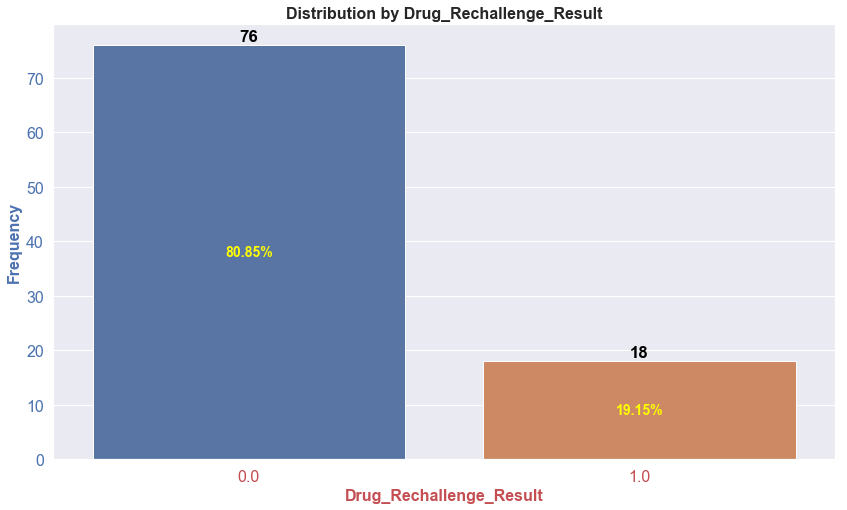

In [53]:
percent_countplot(y_data, col_name='Drug_Rechallenge_Result')

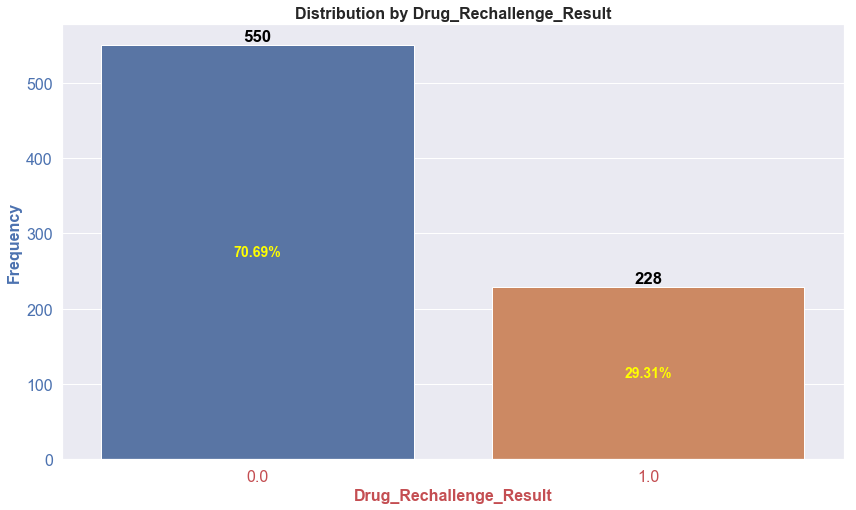

In [54]:
# Counter(y_data_new.Drug_Rechallenge_Result)
percent_countplot(y_data_new, col_name='Drug_Rechallenge_Result')

In [55]:
print(X_encoded_new.shape)
print(y_data_new.shape)

(778, 44)
(778, 1)


In [56]:
print(LogReg_gs_final.best_score_)
print(LogReg_gs_final.best_score_)
print(LogReg_gs_final.best_params_)
print(LogReg_gs_final.best_params_)

print('='*25)
print('Training set performance\n', y_data_new.Drug_Rechallenge_Result.value_counts())
print('='*25)
print(classification_report(LogReg_gs_final.predict(X_encoded_new),y_data_new))

print('='*25)
print('Test set performance\n', y_data_test.Drug_Rechallenge_Result.value_counts())
print('='*25)
print(classification_report(LogReg_gs_final.predict(X_encoded_test),y_data_test))
LogReg_gs_final.best_estimator_

0.9902152641878669
0.9902152641878669
{'C': 25.595479226995334, 'fit_intercept': False}
{'C': 25.595479226995334, 'fit_intercept': False}
Training set performance
 0.000    550
1.000    228
Name: Drug_Rechallenge_Result, dtype: int64
              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99       556
         1.0       0.96      0.99      0.98       222

    accuracy                           0.99       778
   macro avg       0.98      0.99      0.98       778
weighted avg       0.99      0.99      0.99       778

Test set performance
 0.000    10
1.000    10
Name: Drug_Rechallenge_Result, dtype: int64
              precision    recall  f1-score   support

         0.0       0.70      0.70      0.70        10
         1.0       0.70      0.70      0.70        10

    accuracy                           0.70        20
   macro avg       0.70      0.70      0.70        20
weighted avg       0.70      0.70      0.70        20



LogisticRegression(C=25.595479226995334, class_weight=None, dual=False,
                   fit_intercept=False, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=7, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [57]:
print(X_encoded_test.shape)
print(y_data_test.shape)

(20, 44)
(20, 1)


# Final result 

In [58]:
# Concat X_encoded_new and y_data_new 
df_final = pd.concat([X_encoded_new, y_data_new],axis=1).sort_index()
df_final = pd.concat([df['Patient_ID'],df_final],axis=1)
df_final.head()

,Patient_ID,Age_Year,ELISpot_Control,ELISpot_Result,Gender_0,Gender_1,Naranjo_Category_0,Naranjo_Category_1,Naranjo_Category_2,Naranjo_Category_3,Steroid_Usage_0,Steroid_Usage_1,Underlying_Condition_A_0,Underlying_Condition_A_1,Underlying_Condition_B_0,Underlying_Condition_B_1,Underlying_Condition_C_0,Underlying_Condition_C_1,Underlying_Condition_D_0,Underlying_Condition_D_1,Underlying_Condition_E_0,Underlying_Condition_E_1,Suspicion_Score_1,Suspicion_Score_2,Suspicion_Score_3,Allergic_Reaction_Group_1,Allergic_Reaction_Group_2,Allergic_Reaction_Group_3,Allergic_Reaction_Group_4,Allergic_Reaction_Group_5,Allergic_Reaction_Group_6,Allergic_Reaction_Group_7,Allergic_Reaction_Group_8,Drug_Group_1,Drug_Group_2,Drug_Group_3,Drug_Group_4,Drug_Group_5,Drug_Group_6,Drug_Group_7,Drug_Group_8,Ex_Time_group_0,Ex_Time_group_1,Ex_Time_group_2,Ex_Time_group_3,Drug_Rechallenge_Result
0,2,26.000,2504.000,0.000,0.000,1.000,0.000,1.000,0.000,0.000,0.000,1.000,1.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000,0.000,1.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,1.000
1,7,75.000,1868.000,51.000,1.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,1.000
2,13,81.000,1617.000,10.000,1.000,0.000,0.000,1.000,0.000,0.000,0.000,1.000,0.000,1.000,1.000,0.000,1.000,0.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,1.000
3,13,81.000,1617.000,10.000,1.000,0.000,0.000,1.000,0.000,0.000,0.000,1.000,0.000,1.000,1.000,0.000,1.000,0.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,1.000
4,18,60.000,3136.000,0.000,0.000,1.000,0.000,1.000,0.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000,0.000,1.000,0.000,1.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000


In [59]:
# save the model to disk
filename = './Model/LogReg_gs_active.pkl'
pickle.dump(LogReg_gs_final, open(filename, 'wb'))

# Load the model to disk
# filename = './Model/LogReg_gs_active.pkl'
# Logreg_Model = pickle.load(open(filename,"rb"))

In [60]:
coef_dict = {}
coef_dict['intercept'] = LogReg_gs_final.best_estimator_.intercept_.ravel()[0]
for coef, feat in zip(LogReg_gs_final.best_estimator_.coef_.ravel(),X_encoded_new.columns):
    coef_dict[feat] = coef
display(sorted(coef_dict.items(), key= lambda kv:kv[1], reverse=True)[:15])

[('Suspicion_Score_2', 8.992123672745603),
 ('Drug_Group_2', 3.230365059583836),
 ('Ex_Time_group_0', 2.5271528943565613),
 ('Allergic_Reaction_Group_2', 2.2915952830316764),
 ('Allergic_Reaction_Group_8', 2.1945333895577654),
 ('Drug_Group_4', 1.5313768603407871),
 ('Allergic_Reaction_Group_5', 1.4054712027281355),
 ('Drug_Group_5', 1.0879478999446817),
 ('Underlying_Condition_A_1', 0.8572066098922598),
 ('Drug_Group_6', 0.6737500958429447),
 ('Naranjo_Category_2', 0.4561750527804478),
 ('Allergic_Reaction_Group_4', 0.39489902169385793),
 ('Naranjo_Category_3', 0.25359625105651934),
 ('Underlying_Condition_D_0', 0.17701155754786377),
 ('ELISpot_Result', 0.05834729452885141)]